# Topic modeling playground
In this notebook, different concepts for topic modeling will be tested and evaluated.

In [1]:
# import libraries used in this notebook

import re

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# preprocessing
import nltk

nltk.download('stopwords')
import spacy

# Plotting
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fabi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Structure

In [2]:
from enum import Enum


class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5

## Preprocessing

In [3]:
nlp = spacy.load('de_core_news_md')
from nltk.corpus import stopwords
from spacy.lang.de.stop_words import STOP_WORDS

# stopwords
nltk_stopwords = stopwords.words('german')

# build stopwords list
all_stopwords = list(set(STOP_WORDS) | set(nltk_stopwords))
with open('custom_stopwords.txt', 'r', encoding='utf-8') as f:
    all_stopwords += [line.strip() for line in f.readlines()]

# Load files
party_text = {}
for party in Party:
    all_stopwords.extend(['{}'.format(party.name.lower())])
    with open('../resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l for l in txt)
        # remove gender *
        file = re.sub(r'\*innen(\w*)\s', r'\1 ', file)
    party_text[party] = file



In [4]:
def prepare_data(parties: [Party]):
    # get sections
    sections = []
    for partie in parties:
        sections_of_partie = re.split(r'\n\s*\n', party_text[partie])
        sections.extend(sections_of_partie)

    partie_wordbags_mod = []

    for section in sections:
        partie_wordbag = gensim.utils.simple_preprocess(section)

        #filter stopwords
        partie_wordbag_spacy = [word for word in partie_wordbag if word not in all_stopwords]

        partie_wordbags_mod.append(partie_wordbag_spacy)

    # make bigrams / trigrams
    bigram = gensim.models.Phrases(partie_wordbags_mod, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[partie_wordbags_mod], threshold=100)

    bigram_phraser = gensim.models.phrases.Phraser(bigram)
    trigram_phraser = gensim.models.phrases.Phraser(trigram)

    def make_bigrams(texts):
        return [bigram_phraser[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in all_stopwords])
        return texts_out

    words_trigrams = make_trigrams(partie_wordbags_mod)
    words_lematized = lemmatization(words_trigrams)

    id2word = corpora.Dictionary(words_lematized)
    texts = words_lematized
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, words_lematized

In [5]:

corpus, id2word, words_lematized = prepare_data([Party.FDP])
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            iterations=100
                                            )

lda_model.print_topics(num_topics=10, num_words=10)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.06423697067984

Coherence Score:  -5.057632188038246


## Visualization

In [6]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

c:\users\fabi\pycharmprojects\textanalytics\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.020468  0.004084       1        1  16.291845
3     -0.040937 -0.081145       2        1  14.882042
4     -0.066112  0.001188       3        1  13.972535
1     -0.011899  0.074536       4        1  12.040718
2     -0.027527 -0.046349       5        1   8.024945
8     -0.007823  0.061492       6        1   7.973141
0      0.009012 -0.007946       7        1   7.756570
9     -0.001323  0.029992       8        1   7.183877
7      0.091681 -0.015548       9        1   6.506334
6      0.075398 -0.020303      10        1   5.367992, topic_info=             Term       Freq      Total Category  logprob  loglift
1092    beruflich  13.000000  13.000000  Default  30.0000  30.0000
341   unternehmen  50.000000  50.000000  Default  29.0000  29.0000
16        bildung  24.000000  24.000000  Default  28.0000  28.0000
1116  hochschulen  10.000000  10.000000  Default  27.0000  27.0000
44       freiheit  23.000000  23.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
322    regelungen   1.567094  10.459044  Topic10  -6.0008   1.0265
976       schulen   1.768655  19.186825  Topic10  -5.8798   0.5407
21        chancen   1.723780  30.993157  Topic10  -5.9055   0.0355
23        digital   1.717519  36.520428  Topic10  -5.9092  -0.1323
320        privat   1.594988  23.211910  Topic10  -5.9832   0.2469

[724 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2973      1  0.624175       ablösung
4039      8  0.745905  abnahmepreise
360       1  0.636265   abschreibung
360       3  0.212088   abschreibung
360       7  0.212088   abschreibung
...     ...       ...            ...
529       6  0.163683     ökonomisch
2928      8  0.731687     überhöhung
3017      1  0.624191     überlastet
255       3  0.368823    überzeugung
255       8  0.368823    überzeugung

[1650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 2, 3, 9, 1, 10, 8, 7])

## Other models

In [7]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=10, chunksize=100)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lsi_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lsi_model.print_topics(num_topics=10)

c:\users\fabi\pycharmprojects\textanalytics\venv\lib\site-packages\gensim\models\lsimodel.py:932: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
c:\users\fabi\pycharmprojects\textanalytics\venv\lib\site-packages\gensim\models\lsimodel.py:932: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,



Coherence Score:  -5.359567612732676


[(0,
  '0.288*"unternehmen" + 0.158*"digital" + 0.152*"chancen" + 0.148*"nachhaltig" + 0.142*"entwicklung" + 0.141*"freiheit" + 0.133*"wettbewerb" + 0.133*"digitale" + 0.131*"international" + 0.120*"bildung"'),
 (1,
  '0.357*"bildung" + -0.346*"unternehmen" + 0.296*"schulen" + 0.281*"beruflich" + 0.184*"beruflichen_bildung" + 0.147*"weiterbildung" + 0.140*"hochschulen" + 0.112*"leben" + 0.110*"finanziell" + 0.108*"digital"'),
 (2,
  '-0.437*"unternehmen" + 0.316*"freiheit" + 0.167*"land" + 0.165*"menschenrechte" + -0.164*"altersvorsorge" + -0.135*"gesetzlich" + -0.110*"arbeiten" + 0.108*"global" + 0.104*"nachhaltig" + 0.097*"richtung"'),
 (3,
  '0.234*"unternehmen" + -0.193*"schutz" + 0.153*"bildung" + 0.149*"freiheit" + -0.136*"gewalt" + -0.126*"altersvorsorge" + -0.123*"menschenrechte" + -0.119*"klaren" + -0.114*"polizei" + 0.113*"beruflich"'),
 (4,
  '-0.372*"co" + 0.241*"unternehmen" + 0.208*"freiheit" + -0.191*"klimaschutz" + -0.135*"kraftstoffe" + 0.121*"menschenrechte" + -0.119*

In [8]:
from pprint import pprint

hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word, )
pprint(hdp_model.show_topics())

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=hdp_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.002*demokratisch + 0.001*auflagen + 0.001*kriegsbedingte + '
  '0.001*handlungsfähig + 0.001*rückgriff + 0.001*wind + 0.001*zukunft + '
  '0.001*regelbasierte + 0.001*mobilität + 0.001*wettbewerb + '
  '0.001*stipendiaten + 0.001*strategie + 0.001*freiheitliche + '
  '0.001*gegenentwurf + 0.001*verfassten + 0.001*bedeuten + 0.001*wertvolle + '
  '0.001*raum + 0.001*regionen + 0.001*praktikabilität'),
 (1,
  '0.002*beruflich + 0.002*digital + 0.002*regierung + 0.002*stets + '
  '0.002*beruflichen_bildung + 0.002*chancen + 0.001*kommissare + '
  '0.001*aktionen + 0.001*betracht + 0.001*vorrangig + 0.001*energie + '
  '0.001*weiterbildung + 0.001*neutral + 0.001*fortbildung + 0.001*soweit + '
  '0.001*veröffentlichen + 0.001*pädagogisch + 0.001*teilhaben + '
  '0.001*standort + 0.001*wandels'),
 (2,
  '0.002*kampfstoffe + 0.002*klaren + 0.002*schulen + 0.002*bildung + '
  '0.001*schule + 0.001*modern + 0.001*bewerben + 0.001*wiederum + '
  '0.001*verschärfungen + 0.001*gesetzlic

# Plot coherence score

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt


def plot_coherence_lda(coherence, max_topics, max_iterations, parties, iteration_intervall=25, save=False):
    corpus, id2word, words_lematized = prepare_data(parties)

    data = {}
    for iterations in range(iteration_intervall, max_iterations, iteration_intervall):
        statistics = {}
        for topics in range(1, max_topics):
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=topics,
                                                        iterations=iterations
                                                        )
            coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word,
                                                 coherence=coherence, corpus=corpus)
            coherence_lda = coherence_model_lda.get_coherence()
            statistics[topics] = coherence_lda
        data[iterations] = statistics

    for key, value in data.items():
        plt.plot(list(value.keys()), list(value.values()), label=key)
    plt.legend()
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score for different number of topics')

    if save:
        plt.savefig(
            f'../diagrams/coherence_score/lda/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_coherence_score_{coherence}_for_{parties[0]}_{len(parties)}.png')
    plt.show()

In [ ]:
def plot_coherence_lsi(coherence, max_topics, parties, save=False):
    corpus, id2word, words_lematized = prepare_data(parties)

    statistics = {}
    for topics in range(1, max_topics):
        lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=topics,
                                                    )
        coherence_model_lsi = CoherenceModel(model=lsi_model, texts=words_lematized, dictionary=id2word,
                                             coherence=coherence, corpus=corpus)
        coherence_lsi = coherence_model_lsi.get_coherence()
        statistics[topics] = coherence_lsi

    plt.plot(list(statistics.keys()), list(statistics.values()))
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score for different number of topics')

    if save:
        plt.savefig(
            f'../diagrams/coherence_score/lsi/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_coherence_score_{coherence}_for_{parties[0]}_{len(parties)}.png')
    plt.show()

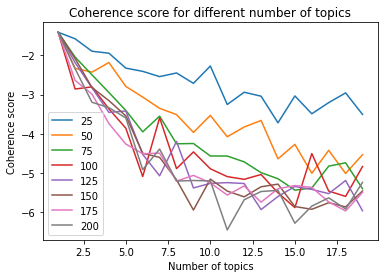

In [ ]:
all_parties = [p for p in Party]

plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=all_parties)

plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.SPD])
plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.CDU])
plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.FDP])
plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.GRUENE])
plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.LINKE])
